STAT 453: Intro to Deep Learning and Generative Models (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

## Gradient descent theory
[Slides](https://sebastianraschka.com/pdf/lecture-notes/stat453ss21/L05_gradient-descent_slides.pdf) and [lecture video](https://www.youtube.com/watch?v=L4xzybIa-bo&t=520s)
<div>
<img src="Screenshot_20230101_013641.png" width="700"/>
</div>
<div>
<img src="Screenshot_20230101_020211.png" width="700"/>
</div>

Recall $$\nabla_w L=\left(\frac{\partial L}{\partial w_1},\dots \right)$$
and $$\sigma(\mathbf w^Tx^{[i]})=\hat{y}^{[i]}$$
This should help justify part 2.A.(b) in the first slide above

<div>
<img src="Screenshot_20230101_023127.png" width="700"/>
</div>

See above for normalization of inputs

# Linear Regression with Gradient Descent

![](figures/adaline-concept.png)

Note that linear regression and Adaline are very similar. The only difference is that we apply a threshold function for converting the outputs from continuous targets for predictions. The derivative and training procedure are identical to Adaline though. You can compare the two notebooks (this one and `adaline-sgd.ipynb`) side by side as shown below to see the relationship:

![](figures/adaline-vs-linreg.png)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

<br>
<br>

## Load & Prepare a Toy Dataset

In [8]:
df = pd.read_csv('./datasets/linreg-data.csv', index_col=0)
df.tail()

,x1,x2,y
995,-0.942094,-0.835856,-22.324428
996,1.222445,-0.403177,-52.121493
997,-0.112466,-1.688230,-57.043196
998,-0.403459,-0.412272,-27.701833
999,0.021351,-0.499017,-9.804714


At time 1:59 of his [video](https://www.youtube.com/watch?v=GGcaqzhKzLc&t=30s), Raschka states that this a (multivariate) regression problem. Apparently the Adaline code (discussed later at time 20:21 in the video) uses a different (classification) data set in which the $y$ values are class labels. While the Adaline data set is a classification set, the Adaline model also uses OLS regression theory (more accurately logistic regression?)

In [9]:
# Assign features and target

X = torch.tensor(df[['x1', 'x2']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.float)

# Shuffling & train/test split

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent70 = int(shuffle_idx.size(0)*0.7)   # an integer which is 70% of the size of the dataset

X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]

# Normalize (mean zero, unit variance)

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

<br>
<br>

## Implement Linear Regression Model
According to time 5:39 of this [video](https://www.youtube.com/watch?v=GGcaqzhKzLc&list=PLTKMiZHVd_2KJtIXOW0zFhFfBaJJilH51&index=40), Pytorch can 'automatically' implement back propagation

In [10]:
class LinearRegression1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float)
        self.bias = torch.zeros(1, dtype=torch.float)

    def forward(self, x):
        netinputs = torch.add(torch.mm(x, self.weights), self.bias)
        activations = netinputs     # activation function is identity
        return activations.view(-1)
        
    def backward(self, x, yhat, y):  
        
        grad_loss_yhat = 2*(yhat - y)
        
        grad_yhat_weights = x
        grad_yhat_bias = 1.
        
        # Chain rule: inner times outer
        grad_loss_weights =  torch.mm(grad_yhat_weights.t(),
                                         grad_loss_yhat.view(-1, 1)) / y.size(0)

        grad_loss_bias = torch.sum(grad_yhat_bias*grad_loss_yhat) / y.size(0)
        
        # return negative gradient
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias

<br>
<br>

## Define Training and Evaluation Functions

In [11]:
####################################################
##### Training and evaluation wrappers
###################################################

def loss(yhat, y):
    return torch.mean((yhat - y)**2)


def train(model, x, y, num_epochs, learning_rate=0.01):
    cost = []
    for e in range(num_epochs):

        #### Compute outputs ####
        yhat = model.forward(x)

        #### Compute gradients ####
        negative_grad_w, negative_grad_b = model.backward(x, yhat, y)

        #### Update weights ####
        model.weights += learning_rate * negative_grad_w
        model.bias += learning_rate * negative_grad_b

        #### Logging ####
        yhat = model.forward(x) # not that this is a bit wasteful here
        curr_loss = loss(yhat, y)
        print('Epoch: %03d' % (e+1), end="")
        print(' | MSE: %.5f' % curr_loss)
        cost.append(curr_loss)

    return cost

<br>
<br>

## Train Linear Regression Model

In [12]:
model = LinearRegression1(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train, 
             num_epochs=100, 
             learning_rate=0.05)

Epoch: 001 | MSE: 1532.67603
Epoch: 002 | MSE: 1312.39868
Epoch: 003 | MSE: 1133.91809
Epoch: 004 | MSE: 989.30286
Epoch: 005 | MSE: 872.12592
Epoch: 006 | MSE: 777.18097
Epoch: 007 | MSE: 700.24915
Epoch: 008 | MSE: 637.91241
Epoch: 009 | MSE: 587.40167
Epoch: 010 | MSE: 546.47284
Epoch: 011 | MSE: 513.30811
Epoch: 012 | MSE: 486.43430
Epoch: 013 | MSE: 464.65799
Epoch: 014 | MSE: 447.01224
Epoch: 015 | MSE: 432.71332
Epoch: 016 | MSE: 421.12634
Epoch: 017 | MSE: 411.73697
Epoch: 018 | MSE: 404.12827
Epoch: 019 | MSE: 397.96249
Epoch: 020 | MSE: 392.96603
Epoch: 021 | MSE: 388.91708
Epoch: 022 | MSE: 385.63583
Epoch: 023 | MSE: 382.97684
Epoch: 024 | MSE: 380.82202
Epoch: 025 | MSE: 379.07571
Epoch: 026 | MSE: 377.66052
Epoch: 027 | MSE: 376.51367
Epoch: 028 | MSE: 375.58420
Epoch: 029 | MSE: 374.83102
Epoch: 030 | MSE: 374.22055
Epoch: 031 | MSE: 373.72586
Epoch: 032 | MSE: 373.32489
Epoch: 033 | MSE: 372.99994
Epoch: 034 | MSE: 372.73657
Epoch: 035 | MSE: 372.52313
Epoch: 036 | MSE:

<br>
<br>

## Evaluate Linear Regression Model

### Plot MSE

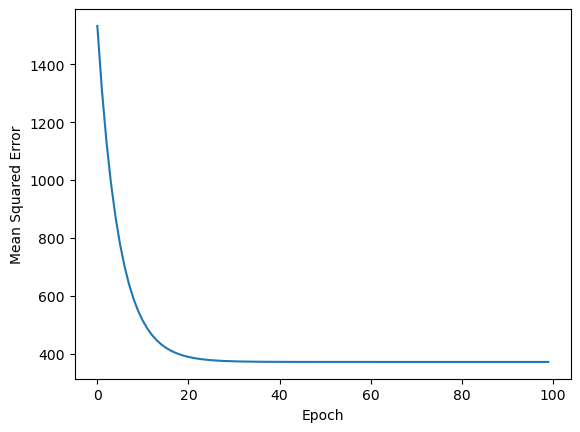

In [13]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [11]:
train_pred = model.forward(X_train)
test_pred = model.forward(X_test)

print('Train MSE: %.5f' % loss(train_pred, y_train))
print('Test MSE: %.5f' % loss(test_pred, y_test))

Train MSE: 371.61035
Test MSE: 406.88412


<br>
<br>

### Compare with analytical solution

In [14]:
print('Weights', model.weights)
print('Bias', model.bias)

Weights tensor([[ 0.3623],
        [37.8790]])
Bias tensor([-0.5464])


In [11]:
def analytical_solution(x, y):
    Xb = torch.cat( (torch.ones((x.size(0), 1)), x), dim=1)
    w = torch.zeros(x.size(1))
    z = torch.inverse(torch.matmul(Xb.t(), Xb))
    params = torch.matmul(z, torch.matmul(Xb.t(), y))
    b, w = torch.tensor([params[0]]), params[1:].view(x.size(1), 1)
    return w, b

w, b = analytical_solution(X_train, y_train)
print('Analytical weights', w)
print('Analytical bias', b)

Analytical weights tensor([[ 0.3624],
        [37.8801]])
Analytical bias tensor([-0.5464])


<br>
<br>

## (Ungraded) HW Exercises

Modify the `train()` function such that the dataset is shuffled prior to each epoch. Do you see a difference -- Yes/No? Try to come up with an explanation for your observation.

